In [1]:
import os
import sys

sys.path.append("./")  # Adds higher directory to python modules path.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from data_pipeline import create_dataset

Let's load the dataset and  select the columns we want to use as features and labels.

## Dataset and Feature Selection

In [2]:
OUTPUT = "Presence_TV"

In [3]:
x_all, y_all = create_dataset(output=OUTPUT)
x_train_val, x_test, y_train_val, y_test = train_test_split(x_all, y_all, test_size=0.1, random_state=42)



### Imbalanced Dataset Handling
We use SMOTE to oversample the minority class.
https://imbalanced-learn.org/stable/index.html

In [4]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE (oversampling)
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_train_val, y_train_val = smote.fit_resample(x_train_val, y_train_val )
y_train_val = y_train_val.reshape(-1, 1)
print(x_train_val.shape, y_train_val.shape)

(15842, 61) (15842, 1)


## Constants and dataset splitting

In [5]:
BATCH_SIZE = 16
EPOCHS = 50
OPTIMIZER = tf.keras.optimizers.Adam(0.001)
LOSS = tf.keras.losses.BinaryCrossentropy()
FEATURE_NUM = x_train_val.shape[1]
print("Feature Number", FEATURE_NUM)

Feature Number 61


In [6]:
from collections import Counter
def get_class_distribution(data):

    # Extract all labels from the dataset
    all_labels = []

    for _, label in data:  # Iterate over the dataset
        all_labels.append(label.numpy())  # Convert label tensors to NumPy arrays

    # Flatten the list in case labels are multi-dimensional
    all_labels = [i[0] for k in all_labels for i in list(k)]
    # Count occurrences of each label
    label_counts = Counter(all_labels)

    # Calculate the ratio for each label
    total_samples = sum(label_counts.values())
    label_ratios = {label: count / total_samples for label, count in label_counts.items()}

    # Print out the labels and their ratios
    print("Label Counts:", label_counts)
    print("Label Ratios:", label_ratios)



In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1, random_state=42)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

print("Training size", len(train_ds))
get_class_distribution(train_ds)

print("Validation size", len(val_ds))
get_class_distribution(val_ds)

print("Test size", len(test_ds))
get_class_distribution(test_ds)

Training size 892
Label Counts: Counter({1.0: 7143, 0.0: 7114})
Label Ratios: {1.0: 0.5010170442589605, 0.0: 0.4989829557410395}
Validation size 100
Label Counts: Counter({0.0: 807, 1.0: 778})
Label Ratios: {1.0: 0.4908517350157729, 0.0: 0.5091482649842272}
Test size 67
Label Counts: Counter({0.0: 888, 1.0: 184})
Label Ratios: {0.0: 0.8283582089552238, 1.0: 0.17164179104477612}


## Model

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(FEATURE_NUM,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy', 'precision', 'recall'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,089 (160.50 KB)

 Trainable params: 41,089 (160.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(train_ds, epochs=EPOCHS,

                    validation_data=val_ds)


Epoch 1/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6636 - loss: 256.7853 - precision: 0.6409 - recall: 0.7502 - val_accuracy: 0.8479 - val_loss: 4.0097 - val_precision: 0.7835 - val_recall: 0.9537
Epoch 2/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7373 - loss: 16.2855 - precision: 0.7538 - recall: 0.6987 - val_accuracy: 0.7893 - val_loss: 0.4473 - val_precision: 0.8049 - val_recall: 0.7532
Epoch 3/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8294 - loss: 0.5858 - precision: 0.7763 - recall: 0.9215 - val_accuracy: 0.8606 - val_loss: 0.3126 - val_precision: 0.7935 - val_recall: 0.9679
Epoch 4/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8652 - loss: 0.3321 - precision: 0.8025 - recall: 0.9671 - val_accuracy: 0.7546 - val_loss: 0.4989 - val_precision: 0.6714 - val_recall: 0.9794
Epoch 5/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8290 - loss: 0.4515 - precision: 0.7606 - recall: 0.9581 - val_accuracy: 0.8498 - val_loss:

## Visualization

Text(0.5, 0, 'Epoch')

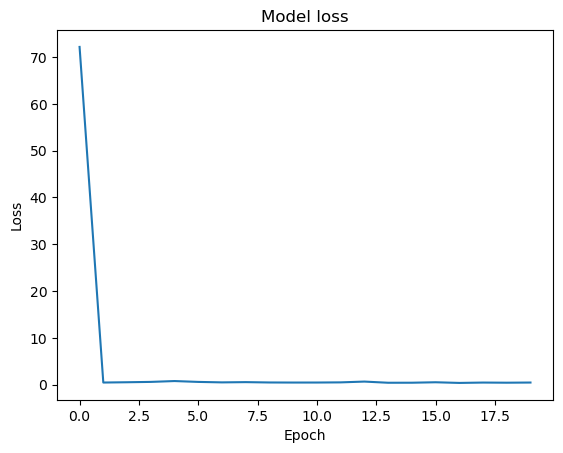

In [16]:

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

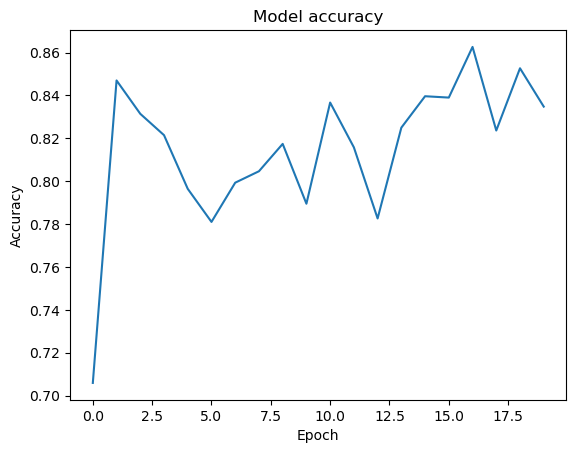

In [17]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [18]:
train_result =  model.evaluate(train_ds    )
val_result = model.evaluate(val_ds)
test_result = model.evaluate(test_ds)

1783/1783 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8509 - loss: 0.3501 - precision: 0.7815 - recall: 0.9713
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8727 - loss: 0.3357 - precision: 0.8012 - recall: 0.9821
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7785 - loss: 0.3799 - precision: 0.4417 - recall: 0.9731


In [19]:
print("Train")
print("Accuracy", train_result[1])
print("Precision", train_result[2])
print("Recall", train_result[3])
print("#" * 10)
print("Validation")
print("Accuracy", val_result[1])
print("Precision", val_result[2])
print("Recall", val_result[3])
print("#" * 10)
print("Test")
print("Accuracy", test_result[1])
print("Precision", test_result[2])
print("Recall", test_result[3])


Train
Accuracy 0.8585256338119507
Precision 0.7929812669754028
Recall 0.9711605906486511
##########
Validation
Accuracy 0.8649842143058777
Precision 0.7931392788887024
Recall 0.980719804763794
##########
Test
Accuracy 0.7826492786407471
Precision 0.4395061731338501
Recall 0.967391312122345
